# Re-parametrizing the Ostriker model to increase flexibility

Trying to fit the Ostriker polytropic model on hydro simulations can lead to a puzzling result: even when trying to fit them jointly, it looks impossible to get a satisfying fit on the gas density and pressure. Let's highlight the problem and offer a solution by re-parametrizing the polytropic model to break the $(\rho_{\rm g, 0}, P_{\rm g, 0})$ degeneracy.

In [1]:
%matplotlib widget

In [2]:
import jax.numpy as jnp
from jax import jit, grad, value_and_grad
import optax
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from tqdm import trange

import sys
sys.path.append("..")
from picasso import cic, utils
import picasso.polytrop_ostriker as ppo
import picasso.polytrop as pp

cosmo = FlatLambdaCDM(67.66, 0.30964, Ob0=0.04897)

def read_hdf5(file_name, jax=False):
    arr_func = jnp.array if jax else np.array
    with h5py.File(file_name, "r") as f:
        grids = {k: arr_func(v) for k, v in f.items()}
    return grids

## Reading in data

We'll use data from the 576 runs. Specifically, we will take a random halo in the lightcone shell from step 567 ($z \simeq 0.1$).

In [3]:
path = "/Users/fkeruzore/Data/HACC/576/LIGHTCONE"
step = "567"

halos_ad = read_hdf5(f"{path}/AD/halos_{step}.h5")
halos_go = read_hdf5(f"{path}/GO/halos_{step}.h5")
pairs = Table.read(f"{path}/PAIRS/halos_{step}.h5", format="hdf5")
parts_ad = read_hdf5(f"{path}/AD/sodbighaloparticles_{step}.h5")
parts_go = read_hdf5(f"{path}/GO/sodbighaloparticles_{step}.h5")

### Halo selection

In [4]:
# pair = pairs[np.random.randint(0, len(pairs))]
pair = pairs[11]
i_go = np.where((halos_go["fof_halo_tag"] == pair["GO"]))[0][0]
i_ad = np.where((halos_ad["fof_halo_tag"] == pair["AD"]))[0][0]
h_go = {k: v[i_go] for k, v in halos_go.items()}
h_ad = {k: v[i_ad] for k, v in halos_ad.items()}

a = h_go["fof_halo_center_a"]
z = 1.0 / a - 1.0
adot = (cosmo.H(z) * a).to("km s-1 Mpc-1").value / cosmo.h

print("======   HALO GO   ======")
print(f"M500 = {h_go['sod_halo_M500c']:.2e} h-1 Msun")
print(f"R500 = {h_go['sod_halo_R500c']:.3f} h-1 cMpc")
print("======   HALO AD   ======")
print(f"M500 = {h_ad['sod_halo_M500c']:.2e} h-1 Msun")
print(f"R500 = {h_ad['sod_halo_R500c']:.3f} h-1 cMpc")

======   HALO GO   ======
M500 = 2.59e+13 h-1 Msun
R500 = 0.377 h-1 cMpc
======   HALO AD   ======
M500 = 2.50e+13 h-1 Msun
R500 = 0.373 h-1 cMpc


### Particles, gravity-only

In [5]:
wp_go = parts_go["fof_halo_tag"] == pair["GO"]
p_go = {k: v[wp_go] for k, v in parts_go.items()}

p_go["r"] = np.sqrt(
      np.fmod((p_go["x"] - h_go["fof_halo_center_x"]), 576.0) ** 2
    + np.fmod((p_go["y"] - h_go["fof_halo_center_y"]), 576.0) ** 2
    + np.fmod((p_go["z"] - h_go["fof_halo_center_z"]), 576.0) ** 2
)  # comoving distance from center, h-1 cMpc
p_go["v2"] = (
      ((a * p_go["vx"] + adot * p_go["x"]) - (a * h_go["fof_halo_com_vx"] + adot * h_go["fof_halo_center_x"])) ** 2
    + ((a * p_go["vy"] + adot * p_go["y"]) - (a * h_go["fof_halo_com_vy"] + adot * h_go["fof_halo_center_y"])) ** 2
    + ((a * p_go["vz"] + adot * p_go["z"]) - (a * h_go["fof_halo_com_vz"] + adot * h_go["fof_halo_center_z"])) ** 2
)  # proper squared velocity, km2 s-2
p_go["phi"] -= p_go["phi"].min() 
p_go["mass"] = np.ones_like(p_go["x"]) * 1.3428e09  # h-1 Msun

### Particles, adiabatic

In [6]:
wp_ad = parts_ad["fof_halo_tag"] == pair["AD"]
p_ad = {k: v[wp_ad] for k, v in parts_ad.items()}
p_ad["r"] = np.sqrt(
      np.fmod((p_ad["x"] - h_ad["fof_halo_center_x"]), 576.0) ** 2
    + np.fmod((p_ad["y"] - h_ad["fof_halo_center_y"]), 576.0) ** 2
    + np.fmod((p_ad["z"] - h_ad["fof_halo_center_z"]), 576.0) ** 2
)  # comoving distance from center, h-1 cMpc
p_ad["v2"] = (
      ((a * p_ad["vx"] + adot * p_ad["x"]) - (a * h_ad["fof_halo_com_vx"] + adot * h_ad["fof_halo_center_x"])) ** 2
    + ((a * p_ad["vy"] + adot * p_ad["y"]) - (a * h_ad["fof_halo_com_vy"] + adot * h_ad["fof_halo_center_y"])) ** 2
    + ((a * p_ad["vz"] + adot * p_ad["z"]) - (a * h_ad["fof_halo_com_vx"] + adot * h_ad["fof_halo_center_z"])) ** 2
)  # proper squared velocity, km2 s-2
p_ad["is_gas"] = (  # part is gas if part:
    (np.bitwise_and(p_ad["mask"], 2**2) > 0)  # is not CDM
    & (np.bitwise_and(p_ad["mask"], 2**3) == 0)  # is not AGN
    & (np.bitwise_and(p_ad["mask"], 2**4) == 0)  # is not star
    & (np.bitwise_and(p_ad["mask"], 2**5) == 0)  # is not wind
)
p_ad["P_th"] = (2 / 3) * p_ad["rho"] * p_ad["uu"]
p_ad["P_nt"] = (1 / 3) * p_ad["rho"] * p_ad["v2"]
for p in ["P_th", "P_nt"]:
    p_ad[p] = np.where(p_ad["is_gas"], p_ad[p], np.nan)
p_ad_g = {k: v[p_ad["is_gas"]] for k, v in p_ad.items()}

### Data vectors

The fit will be performed on the 1D azimuthally-averaged gas density and total (thermal + kinetic) profiles.

In [7]:
r_edges_R500 = np.logspace(-1.3, 0.3, 16)
r_R500 = r_edges_R500[:-1] + 0.5 * np.ediff1d(r_edges_R500)
norms = {"rho": 1e14, "P": 1e20}

_, rho_ad_1d, drho_ad_1d = utils.azimuthal_profile(
    p_ad_g["rho"] / norms["rho"],
    p_ad_g["r"] / h_ad["sod_halo_R500c"],
    r_edges_R500,
)
_, P_ad_1d, dP_ad_1d = utils.azimuthal_profile(
    (p_ad_g["P_th"] + p_ad_g["P_nt"]) / norms["P"],
    p_ad_g["r"] / h_ad["sod_halo_R500c"],
    r_edges_R500,
)
r_R500_go = p_go["r"] / h_go["sod_halo_R500c"]

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



/var/folders/3t/_vtqsjsx3hq7ktlc27qg58c00000gr/T/ipykernel_10269/3052222698.py:5: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  _, rho_ad_1d, drho_ad_1d = utils.azimuthal_profile(
2023-09-29 10:26:20.658169: W pjrt_plugin/src/mps_client.cc:535] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
/var/folders/3t/_vtqsjsx3hq7ktlc27qg58c00000gr/T/ipykernel_10269/3052222698.py:10: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  _, P_ad_1d, dP_ad_1d = utils.azimuthal_profile(


## Fitting the model

### Original Ostriker model

Let's fit the Ostriker model from the gravity-only potential using three different loss functions:

1. Fitting on $\rho_{\rm g}$ and $P_{\rm g}$ at the same time;
2. Fitting on $\rho_{\rm g}$ alone;
3. Fitting on $P_{\rm g}$ alone.

In [8]:
phi_go = p_go["phi"]

def compute_model(par):
    rho_0, P_0 = 10**par[:2]
    Gamma = par[2]
    rho_mod_3d, P_mod_3d = ppo.rho_P_g(phi_go, rho_0, P_0, Gamma)
    _, rho_mod_1d, _ = utils.azimuthal_profile(rho_mod_3d / norms["rho"], r_R500_go, r_edges_R500)
    _, P_mod_1d, _ = utils.azimuthal_profile(P_mod_3d / norms["P"], r_R500_go, r_edges_R500)
    return rho_mod_1d, P_mod_1d

def loss_fn_rhoP(par):
    rho_mod, P_mod = compute_model(par)
    return 0.5 * (
          jnp.mean(((rho_ad_1d - rho_mod) / drho_ad_1d)**2)
        + jnp.mean(((P_ad_1d - P_mod) / dP_ad_1d)**2)
    )

def loss_fn_rho_only(par):
    rho_mod, P_mod = compute_model(par)
    return jnp.mean(((rho_ad_1d - rho_mod) / drho_ad_1d)**2)

def loss_fn_P_only(par):
    rho_mod, P_mod = compute_model(par)
    return jnp.mean(((P_ad_1d - P_mod) / dP_ad_1d)**2)

In [9]:
n_steps = 2000

def fit(par, optimizer, loss_fn):
    opt_state = optimizer.init(par)
    chain = []

    @jit
    def step(par, opt_state):
        loss_value, grads = value_and_grad(loss_fn)(par)
        updates, opt_state = optimizer.update(grads, opt_state, par)
        par = optax.apply_updates(par, updates)
        return par, opt_state, loss_value

    for i in range(n_steps):
        par, opt_state, loss_value = step(par, opt_state)
        chain.append([*par, loss_value])
        if i % (n_steps / 5) == 0:
            print(f"Step {i}; Loss: {loss_value:.5f}")
    return jnp.array(chain)

chains = {}
par_i = jnp.array([
    jnp.log10(rho_ad_1d[0] * norms["rho"]),
    jnp.log10(P_ad_1d[0] * norms["P"]),
    1.2
])
for loss_fn, label in zip(
    [loss_fn_rhoP, loss_fn_rho_only, loss_fn_P_only], 
    ["Fit both", "Fit rho", "Fit P"]
):
    print(f"==> {label}")
    optimizer = optax.adam(learning_rate=1e-2)
    chain = fit(par_i, optimizer, loss_fn)
    chains[label] = chain

==> Fit both
Step 0; Loss: 52.74058
Step 400; Loss: 17.28893
Step 800; Loss: 17.28925
Step 1200; Loss: 17.28957
Step 1600; Loss: 17.28957
==> Fit rho
Step 0; Loss: 53.30407
Step 400; Loss: 5.97905
Step 800; Loss: 5.97905
Step 1200; Loss: 5.97905
Step 1600; Loss: 5.97905
==> Fit P
Step 0; Loss: 52.17708
Step 400; Loss: 0.12360
Step 800; Loss: 0.01611
Step 1200; Loss: 0.01396
Step 1600; Loss: 0.01396


Text(0, 0.5, '$\\Delta P / P$')

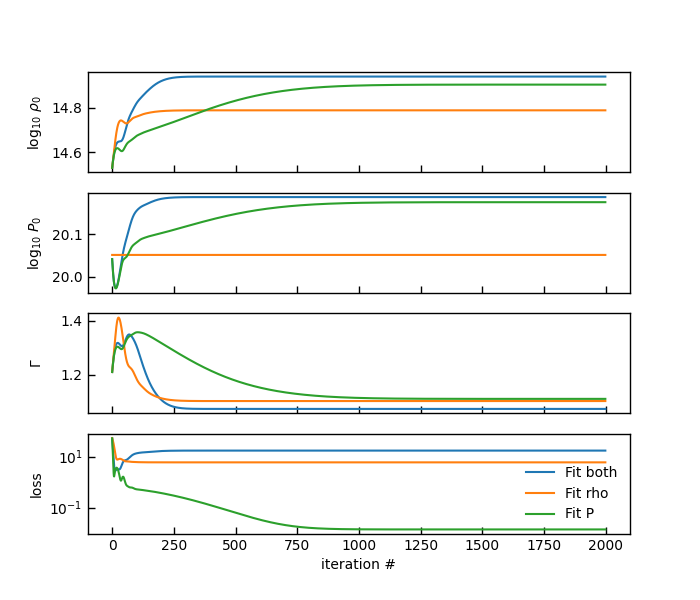

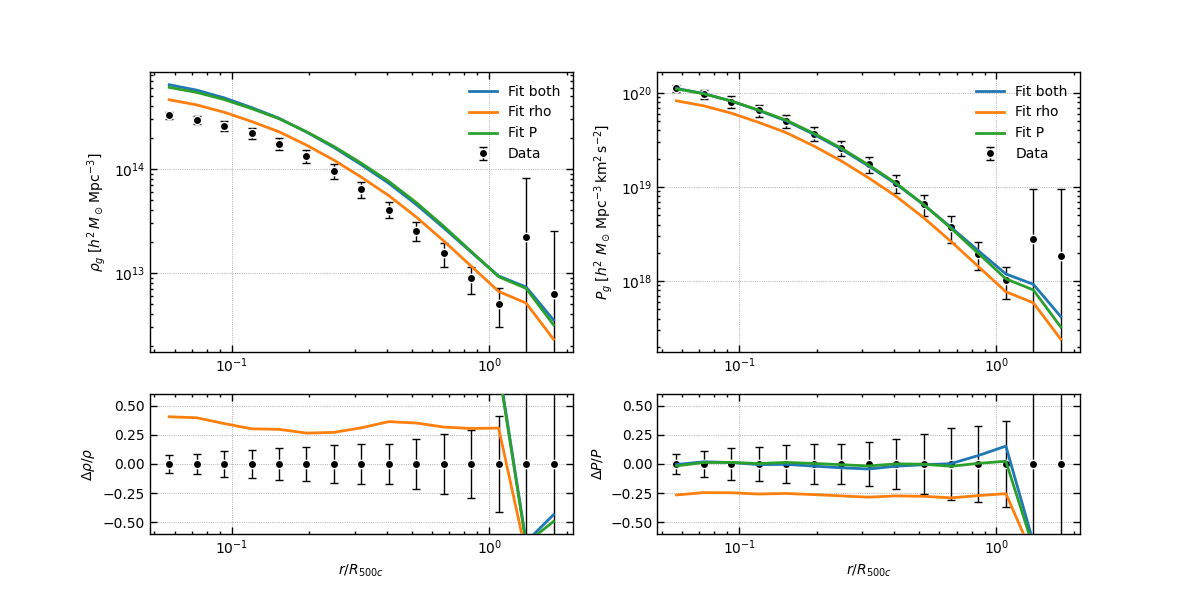

In [10]:
fig1, axs1 = plt.subplots(4, 1, figsize=(7, 6))
fig2 = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 2, height_ratios=[2, 1])
axs_dat = [fig2.add_subplot(gs[0]), fig2.add_subplot(gs[1])]
axs_res = [fig2.add_subplot(gs[2]), fig2.add_subplot(gs[3])]

# Plot data profiles
axs_dat[0].errorbar(r_R500, rho_ad_1d * norms["rho"], yerr=drho_ad_1d * norms["rho"], fmt="o", color="k", capsize=3, mec="w", label="Data")
axs_res[0].errorbar(r_R500, np.zeros_like(rho_ad_1d), yerr=drho_ad_1d / rho_ad_1d, fmt="o", color="k", capsize=3, mec="w")
axs_dat[1].errorbar(r_R500, P_ad_1d * norms["P"], yerr=dP_ad_1d * norms["P"], fmt="o", color="k", capsize=3, mec="w", label="Data")
axs_res[1].errorbar(r_R500, np.zeros_like(P_ad_1d), yerr=dP_ad_1d / P_ad_1d, fmt="o", color="k", capsize=3, mec="w")

for label, chain in chains.items():

    # Plot gradient descent in parameter space
    for i, ax in enumerate(axs1):
        ax.plot(np.arange(chain.shape[0]), chain[:, i], lw=1.5, label=label)

    # Plot best-fitting model
    best_par = chain[-1, :-1]
    best_rho, best_P = compute_model(best_par)
    axs_dat[0].loglog(r_R500, best_rho * norms["rho"], lw=2, zorder=10, label=label)
    axs_res[0].semilogx(r_R500, (best_rho - rho_ad_1d) / rho_ad_1d, lw=2, zorder=10)
    axs_dat[1].loglog(r_R500, best_P * norms["P"], lw=2, zorder=10, label=label)
    axs_res[1].semilogx(r_R500, (best_P - P_ad_1d) / P_ad_1d, lw=2, zorder=10)

# Cosmetics
for i, ax in enumerate(axs1):
    ax.set_ylabel(["$\\log_{10} \\, \\rho_0$", "$\\log_{10} \\, P_0$", "$\\Gamma$", "loss"][i])
    if i == len(axs1) - 1:
        ax.set_xlabel("iteration #")
        ax.set_yscale("log")
        ax.legend(frameon=False)
    else:
        ax.set_xticklabels([])
fig1.align_labels()

for ax in axs_dat:
    ax.legend(frameon=False)
    ax.xaxis.set_ticks_position("both")
    ax.yaxis.set_ticks_position("both")
    ax.grid(ls=":", color="0.5")
for ax in axs_res:
    # ax.set_yscale("symlog", linthresh=1e-2)
    ax.set_ylim(-0.6, 0.6)
    # ax.set_yticks(np.arange(-0.4, 0.41, 0.1), minor=True)
    ax.xaxis.set_ticks_position("both")
    ax.yaxis.set_ticks_position("both")
    ax.grid(ls=":", color="0.5")
    ax.set_xlabel("$r / R_{500c}$")
axs_dat[0].set_ylabel("$\\rho_g \\; [h^2 \\, M_\\odot \\, {\\rm Mpc^{-3}}]$")
axs_dat[1].set_ylabel("$P_g \\; [h^2 \\, \\, M_\\odot \\, {\\rm Mpc^{-3} \\, km^2 \\, s^{-2}}]$")
axs_res[0].set_ylabel("$\\Delta \\rho / \\rho$")
axs_res[1].set_ylabel("$\\Delta P / P$")


As we can see, fitting on pressure alone gives okay results for pressure, but not great for density. Inversely, fitting for density gives bad results on pressure. Fitting on both simultaneously seems to lean closer to the results obtained by fitting for pressure alone.

Let's try to fix that.

### Re-parametrized

The gradient descent in parameter space shown above tells us that part of the problem comes from a disagreement between density and pressure on the optimal value of $(\rho_{\rm g, 0}, P_{\rm g, 0})$. Because of the functional form of the polytropic equations in the Ostriker model, they are extremely correlated, and it can be a bit tricky to optimize them both at the same time.

We can bypass that problem by redefining the polytropic variable $\theta$ of Ostriker+05:

$$
\theta(\varphi) = 1 - \frac{\Gamma - 1}{\Gamma} \frac{\rho_{\rm g, 0}}{P_{\rm g, 0}} \varphi,
$$

where $\varphi \equiv \phi - \phi_0$, to:

$$
\theta'(\varphi) = 1 - \frac{\Gamma - 1}{\Gamma} \frac{\rho_{\rm GO, 0}}{P_{\rm GO, 0}} \varphi,
$$

defining $\rho_{\rm GO, 0}$ and $P_{\rm GO, 0}$ as the average density and kinetic energy of the gravity-only particles at the center of the cluster.
This way, $\rho_{\rm g, 0}$ and $P_{\rm g, 0}$ are simply the normalization (and central values) of pasted gas density and pressure, and the factor in front of the potential is fixed by data and does not depend on them anymore.

In [11]:
p_go_0 = {k: v[p_go["r"] < (r_edges_R500[0] * h_go["sod_halo_R500c"])] for k, v in p_go.items()}
rho_0_go = np.sum(p_go_0["mass"]) / ((4.0 / 3.0) * np.pi * (h_go["sod_halo_R500c"] * a)**3)  # h2 Msun Mpc-3
P_0_go = rho_0_go * np.mean(p_go_0["v2"]) * 2 / 3.0  # h2 Msun Mpc-3 km2 s-2

phi_go_norm = p_go["phi"] * rho_0_go / P_0_go

In [12]:
def compute_model(par):
    rho_0, P_0 = 10**par[:2]
    Gamma = par[2]
    rho_mod_3d, P_mod_3d = pp.rho_P_g(phi_go_norm, rho_0, P_0, Gamma)
    _, rho_mod_1d, _ = utils.azimuthal_profile(rho_mod_3d / norms["rho"], r_R500_go, r_edges_R500)
    _, P_mod_1d, _ = utils.azimuthal_profile(P_mod_3d / norms["P"], r_R500_go, r_edges_R500)
    return rho_mod_1d, P_mod_1d

def loss_fn(par):
    rho_mod, P_mod = compute_model(par)
    return 0.5 * (
          jnp.mean(((rho_ad_1d - rho_mod) / drho_ad_1d)**2)
        + jnp.mean(((P_ad_1d - P_mod) / dP_ad_1d)**2)
    )

In [13]:
n_steps = 5000

def fit(par, optimizer, loss_fn):
    opt_state = optimizer.init(par)
    chain = []

    @jit
    def step(par, opt_state):
        loss_value, grads = value_and_grad(loss_fn)(par)
        updates, opt_state = optimizer.update(grads, opt_state, par)
        par = optax.apply_updates(par, updates)
        return par, opt_state, loss_value

    for i in range(n_steps):
        par, opt_state, loss_value = step(par, opt_state)
        chain.append([*par, loss_value])
        if i % (n_steps / 5) == 0:
            print(f"Step {i}; Loss: {loss_value:.5f}")
    return jnp.array(chain)

chains = {}
par_i = jnp.array([
    jnp.log10(rho_ad_1d[0] * norms["rho"]),
    jnp.log10(P_ad_1d[0] * norms["P"]),
    1.2
])

optimizer = optax.adam(learning_rate=1e-4)
chain = fit(par_i, optimizer, loss_fn)
chains[label] = chain


Step 0; Loss: 1.61168
Step 1000; Loss: 0.21935
Step 2000; Loss: 0.15348
Step 3000; Loss: 0.15324
Step 4000; Loss: 0.15324


Text(0, 0.5, '$\\Delta P / P$')

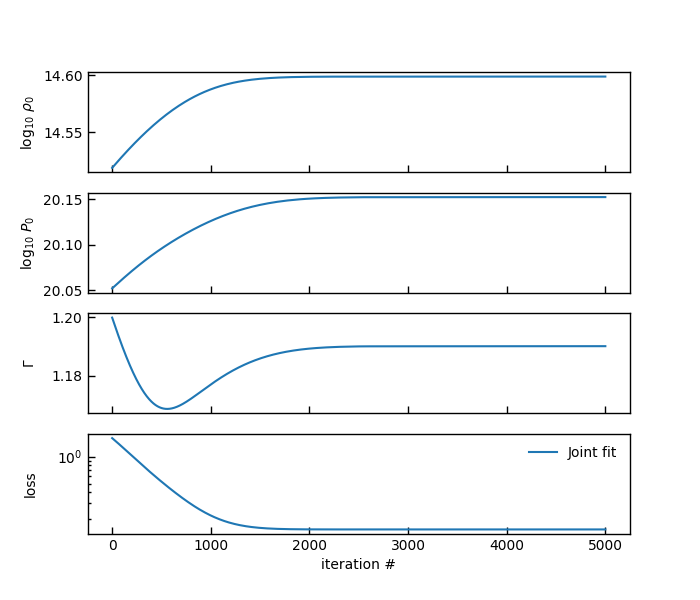

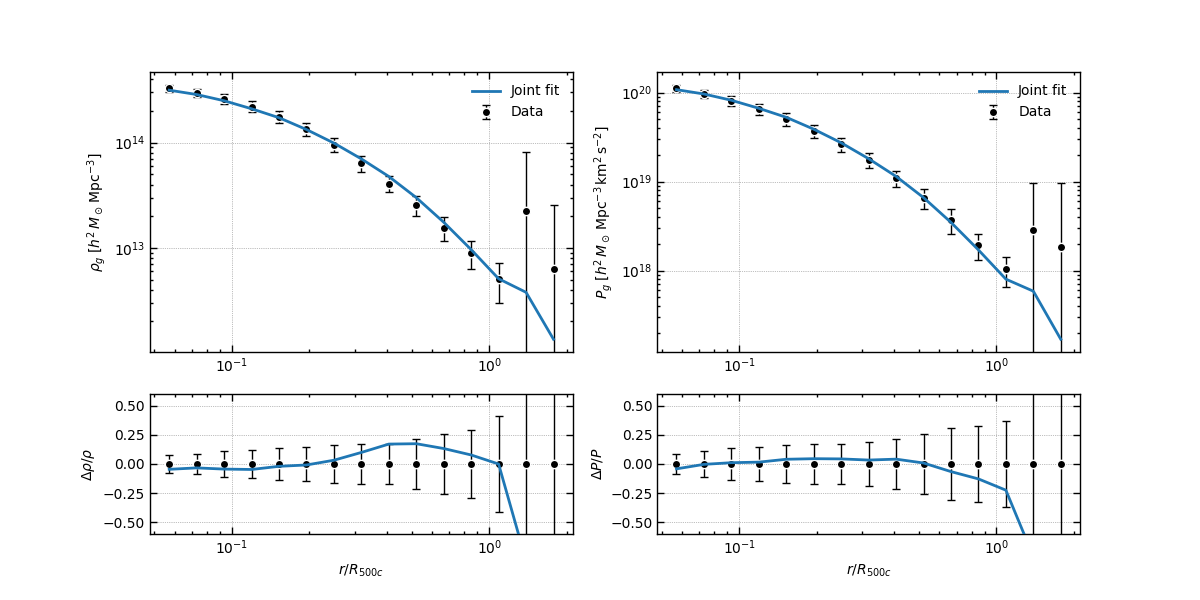

In [14]:
fig1, axs1 = plt.subplots(4, 1, figsize=(7, 6))
fig2 = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 2, height_ratios=[2, 1])
axs_dat = [fig2.add_subplot(gs[0]), fig2.add_subplot(gs[1])]
axs_res = [fig2.add_subplot(gs[2]), fig2.add_subplot(gs[3])]

# Plot data profiles
axs_dat[0].errorbar(r_R500, rho_ad_1d * norms["rho"], yerr=drho_ad_1d * norms["rho"], fmt="o", color="k", capsize=3, mec="w", label="Data")
axs_res[0].errorbar(r_R500, np.zeros_like(rho_ad_1d), yerr=drho_ad_1d / rho_ad_1d, fmt="o", color="k", capsize=3, mec="w")
axs_dat[1].errorbar(r_R500, P_ad_1d * norms["P"], yerr=dP_ad_1d * norms["P"], fmt="o", color="k", capsize=3, mec="w", label="Data")
axs_res[1].errorbar(r_R500, np.zeros_like(P_ad_1d), yerr=dP_ad_1d / P_ad_1d, fmt="o", color="k", capsize=3, mec="w")

# Plot gradient descent in parameter space
label = "Joint fit"
for i, ax in enumerate(axs1):
    ax.plot(np.arange(chain.shape[0]), chain[:, i], lw=1.5, label=label)

# Plot best-fitting model
best_par = chain[-1, :-1]
best_rho, best_P = compute_model(best_par)
axs_dat[0].loglog(r_R500, best_rho * norms["rho"], lw=2, zorder=10, label=label)
axs_res[0].semilogx(r_R500, (best_rho - rho_ad_1d) / rho_ad_1d, lw=2, zorder=10)
axs_dat[1].loglog(r_R500, best_P * norms["P"], lw=2, zorder=10, label=label)
axs_res[1].semilogx(r_R500, (best_P - P_ad_1d) / P_ad_1d, lw=2, zorder=10)

# Cosmetics
for i, ax in enumerate(axs1):
    ax.set_ylabel(["$\\log_{10} \\, \\rho_0$", "$\\log_{10} \\, P_0$", "$\\Gamma$", "loss"][i])
    if i == len(axs1) - 1:
        ax.set_xlabel("iteration #")
        ax.set_yscale("log")
        ax.legend(frameon=False)
    else:
        ax.set_xticklabels([])
fig1.align_labels()

for ax in axs_dat:
    ax.legend(frameon=False)
    ax.xaxis.set_ticks_position("both")
    ax.yaxis.set_ticks_position("both")
    ax.grid(ls=":", color="0.5")
for ax in axs_res:
    # ax.set_yscale("symlog", linthresh=1e-2)
    ax.set_ylim(-0.6, 0.6)
    # ax.set_yticks(np.arange(-0.4, 0.41, 0.1), minor=True)
    ax.xaxis.set_ticks_position("both")
    ax.yaxis.set_ticks_position("both")
    ax.grid(ls=":", color="0.5")
    ax.set_xlabel("$r / R_{500c}$")
axs_dat[0].set_ylabel("$\\rho_g \\; [h^2 \\, M_\\odot \\, {\\rm Mpc^{-3}}]$")
axs_dat[1].set_ylabel("$P_g \\; [h^2 \\, M_\\odot \\, {\\rm Mpc^{-3} \\, km^2 \\, s^{-2}}]$")
axs_res[0].set_ylabel("$\\Delta \\rho / \\rho$")
axs_res[1].set_ylabel("$\\Delta P / P$")

